In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import torch
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm, colors

# Import all surface reparametrization functions
from deepshape.surfaces import *


# Set plotting Parameters
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 16
plt.rcParams["xtick.labelsize"] = 16
plt.rcParams["ytick.labelsize"] = 16

In [3]:
# f = CylinderWrap()
f = HyperbolicParaboloid()
γ = RotationDiffeomorphism().compose(LogStepQuadratic())
# γ = RotationDiffeomorphism()

# Reparametrize f to get target surface g
g = f.compose(γ)

# Get q-maps of the two surfaces
q = Qmap(g)
r = Qmap(f)
# q = SRNF(g)
# r = SRNF(f)

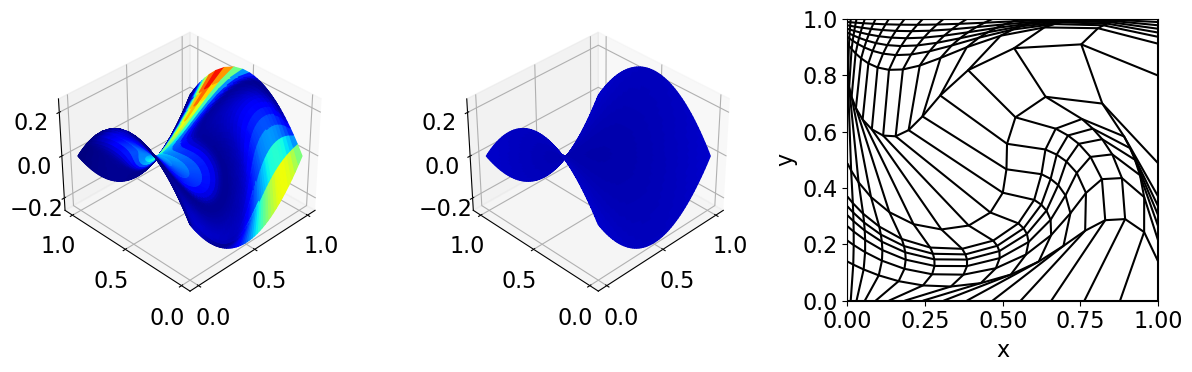

In [4]:
# Create Coloring Functions for plotting
k = 64 # Points per dimension (k^2 points total)
camera = (35, 225)
norm = get_common_colornorm((f, g), k=k)

# Init Figure 
fig = plt.figure(figsize=(12, 4))

# Plot Target surface g
ax = fig.add_subplot(131, projection='3d')
plot_surface(g, ax=ax, k=k, colornorm=norm, camera=camera)

# Plot Inital surface f 
ax = fig.add_subplot(132, projection='3d')
plot_surface(f, ax=ax, k=k, colornorm=norm, camera=camera)

# Plot Target Reparametrization function
ax = fig.add_subplot(133)
plot_diffeomorphism(γ, k=16, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

# Define reparametrization-network
RN = SurfaceReparametrizer(
    [SineLayer(5) for _ in range(15)]
).to(device)

# Define optimizer and learning rate scheduler
# optimizer = optim.SGD(RN.parameters(), lr=1e-1, momentum=0.9)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=0, threshold=0.,
#     threshold_mode='rel', cooldown=1, min_lr=1e-5, eps=1e-08,
#     verbose=True)


optimizer = optim.LBFGS(RN.parameters(), max_iter=100, line_search_fn="strong_wolfe")
scheduler = None

loss_func = SurfaceDistance(q, r, k=32, h=None).to(device)
errors = reparametrize(RN, loss_func, optimizer, 1, Logger(1), scheduler=scheduler)
RN.to("cpu"), loss_func.to("cpu");

[Iter     1] loss: 0.467831
[Iter     2] loss: 0.375484
[Iter     3] loss: 0.207543
[Iter     4] loss: 0.111551
[Iter     5] loss: 0.053387
[Iter     6] loss: 0.044942
[Iter     7] loss: 0.039562
[Iter     8] loss: 0.033989
[Iter     9] loss: 0.027915
[Iter    10] loss: 0.023043
[Iter    11] loss: 0.020217
[Iter    12] loss: 0.015413
[Iter    13] loss: 0.012018
[Iter    14] loss: 0.009847
[Iter    15] loss: 0.008548
[Iter    16] loss: 0.007552
[Iter    17] loss: 0.006490
[Iter    18] loss: 0.004954
[Iter    19] loss: 0.004586
[Iter    20] loss: 0.004275
[Iter    21] loss: 0.004273
[Iter    22] loss: 0.004261
[Iter    23] loss: 0.004253
[Iter    24] loss: 0.004253
[Iter    25] loss: 0.004252
[Iter    26] loss: 0.004251
[Iter    27] loss: 0.004250

Finished training in 30.48252s


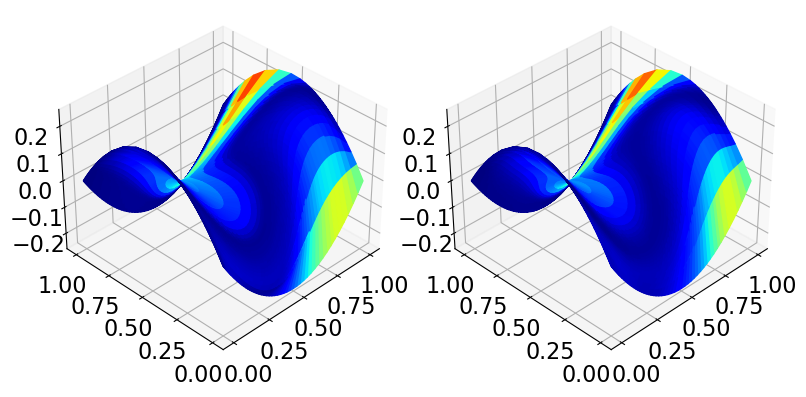

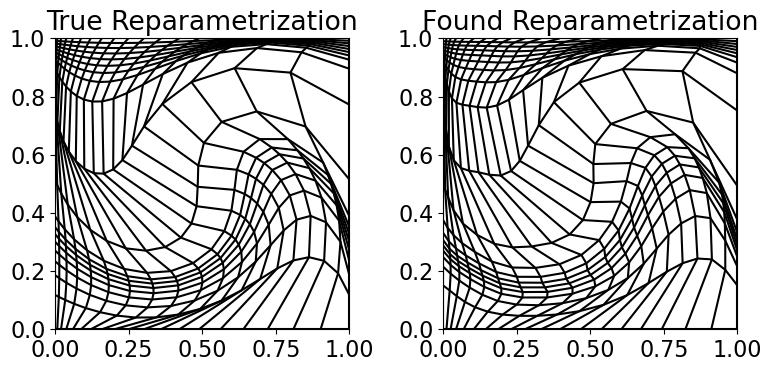

In [6]:
# Reparametrize f
fafter = f.compose(RN)

# Create Coloring Functions for plotting
k = 56 # Points per dimension (k^2 points total)
camera = (35, 225)
norm = get_common_colornorm((f, g, fafter), k=k)

fig = plt.figure(figsize=(8, 4))

# Plot Target surface g
ax = fig.add_subplot(121, projection='3d')
plot_surface(g, ax=ax, k=k, colornorm=norm, camera=camera)

# Plot reparametrized surface f 
ax = fig.add_subplot(122, projection='3d')
plot_surface(fafter, ax=ax, k=k, colornorm=norm, camera=camera)

plt.tight_layout()
plt.show()


fig = plt.figure(figsize=(8, 4))
# Plot Reparametrization function
ax = fig.add_subplot(121)
plot_diffeomorphism(γ, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("True Reparametrization")

# Plot Reparametrization function
ax = fig.add_subplot(122)
plot_diffeomorphism(RN, k=20, color="k", ax=ax)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("Found Reparametrization")

plt.tight_layout()
plt.show()

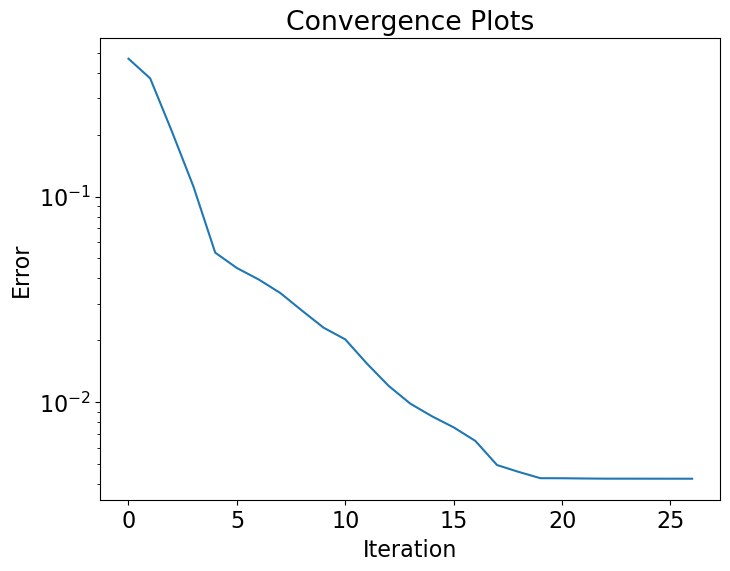

In [7]:
plt.figure()
plt.semilogy(errors)
plt.axhline(0., ls="--", c="black")
plt.ylabel("Error", fontsize=16)
plt.xlabel("Iteration", fontsize=16)
plt.title("Convergence Plots")
plt.show()